In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from thc_net.explainable_model.input_utils import preproc_dataset
from thc_net.explainable_model.model import build_model
from thc_net.explainable_model.random_utils import setup_seed, SEED
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
setup_seed()

<IPython.core.display.Javascript object>

In [5]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

In [7]:
dataset_name = "portoseguro"
filename = "train_bench.csv"
target = "target"
ids = []

<IPython.core.display.Javascript object>

In [8]:
dataset_name = "road-safety"
filename = "train_bench.csv"
target = "Sex_of_Driver_df_res"
ids = []

<IPython.core.display.Javascript object>

In [9]:
dataset_name = "open-payments"
filename = "train_bench.csv"
target = "status"
ids = []

<IPython.core.display.Javascript object>

In [10]:
dataset_name = "give-me-some-credit"
filename = "train_bench.csv"
target = "SeriousDlqin2yrs"
ids = ["Unamed", "age"]

<IPython.core.display.Javascript object>

In [11]:
dataset_name = "census-income"
filename = "train_bench.csv"
target = "taxable income amount"
ids = []

<IPython.core.display.Javascript object>

In [12]:
dataset_name = "bank-marketing"
filename = "train_bench.csv"
target = "y"
ids = []

<IPython.core.display.Javascript object>

In [13]:
dataset_name = "albert"
filename = "train_bench.csv"
target = "target"
ids = []

<IPython.core.display.Javascript object>

In [14]:
dataset_name = "cat-in-the-dat-ii"
filename = "train_bench.csv"
target = "target"
ids = ["id"]

<IPython.core.display.Javascript object>

In [15]:
dataset_name = "bnp-cardif"
filename = "train_bench.csv"
target = "target"
ids = []

<IPython.core.display.Javascript object>

In [16]:
dataset_name = "homesite-quote-conversion"
filename = "train_bench.csv"
target = "QuoteConversion_Flag"
ids = []

<IPython.core.display.Javascript object>

In [17]:
out = Path(os.getcwd()) / "data" / dataset_name / filename

<IPython.core.display.Javascript object>

In [18]:
train = pd.read_csv(out)
train.shape

(260753, 300)

<IPython.core.display.Javascript object>

In [19]:
train.columns

Index(['QuoteNumber', 'Original_Quote_Date', 'QuoteConversion_Flag', 'Field6',
       'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12',
       ...
       'GeographicField59B', 'GeographicField60A', 'GeographicField60B',
       'GeographicField61A', 'GeographicField61B', 'GeographicField62A',
       'GeographicField62B', 'GeographicField63', 'GeographicField64', 'Set'],
      dtype='object', length=300)

<IPython.core.display.Javascript object>

In [20]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index, train[target].values[train_valid_index]
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

<IPython.core.display.Javascript object>

In [21]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [22]:
# train["comment"] = train["comment"].fillna("unknown")

<IPython.core.display.Javascript object>

In [23]:
# max_len = np.percentile(np.vectorize(len)(train["comment"].values), 90)
# max_len

<IPython.core.display.Javascript object>

In [24]:
# train["comment"] = train["comment"].str.slice(0, int(max_len))

<IPython.core.display.Javascript object>

In [25]:
# train["parent_comment"] = train["parent_comment"].fillna("unknown")

<IPython.core.display.Javascript object>

In [26]:
# max_len = np.percentile(np.vectorize(len)(train["parent_comment"].values), 90)
# max_len

<IPython.core.display.Javascript object>

In [27]:
# train["parent_comment"] = train["parent_comment"].str.slice(0, int(max_len))

<IPython.core.display.Javascript object>

In [28]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ids + ["Set"])
params

{'constant_cols': ['PropertyField6', 'GeographicField10A'],
 'bool_cols': ['PersonalField6',
  'GeographicField56A',
  'PropertyField37',
  'GeographicField23A',
  'GeographicField14A',
  'PropertyField8',
  'PropertyField36',
  'PropertyField11A',
  'GeographicField21A',
  'PropertyField32',
  'PropertyField34',
  'PersonalField7',
  'GeographicField62A',
  'Field12',
  'GeographicField18A',
  'GeographicField5A',
  'PropertyField38',
  'PersonalField2',
  'GeographicField22A',
  'PersonalField8',
  'GeographicField61A',
  'PropertyField3',
  'PropertyField2A',
  'GeographicField60A',
  'PropertyField4',
  'GeographicField10B',
  'SalesField9',
  'PropertyField5',
  'SalesField3',
  'PropertyField30',
  'PersonalField1',
  'PropertyField29'],
 'num_cols': ['SalesField8', 'QuoteNumber'],
 'cat_cols': ['SalesField4',
  'PersonalField56',
  'GeographicField11B',
  'PropertyField16B',
  'GeographicField35A',
  'GeographicField19B',
  'CoverageField3A',
  'PersonalField11',
  'GeographicFi

<IPython.core.display.Javascript object>

In [29]:
len(train_indices)

208603

<IPython.core.display.Javascript object>

In [30]:
input_valid, _ = preproc_dataset(
    train.loc[valid_indices], target, ids + ["Set"], params
)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ids + ["Set"], params)

<IPython.core.display.Javascript object>

In [31]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [32]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [33]:
model = build_model(params, lconv_dim=[32, 16], lconv_num_dim=[16],)

<IPython.core.display.Javascript object>

In [34]:
model.get_layer("output")._build_input_shape

TensorShape([None, 4256])

<IPython.core.display.Javascript object>

In [35]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cat (InputLayer)          [(None, 262)]        0                                            
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 262, 16)      13920       input_cat[0][0]                  
__________________________________________________________________________________________________
input_num (InputLayer)          [(None, 6)]          0                                            
__________________________________________________________________________________________________
block_cat_0_conv (LocallyConnec (None, 262, 32)      134144      large_emb[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [36]:
# !pip install pydot graphviz

<IPython.core.display.Javascript object>

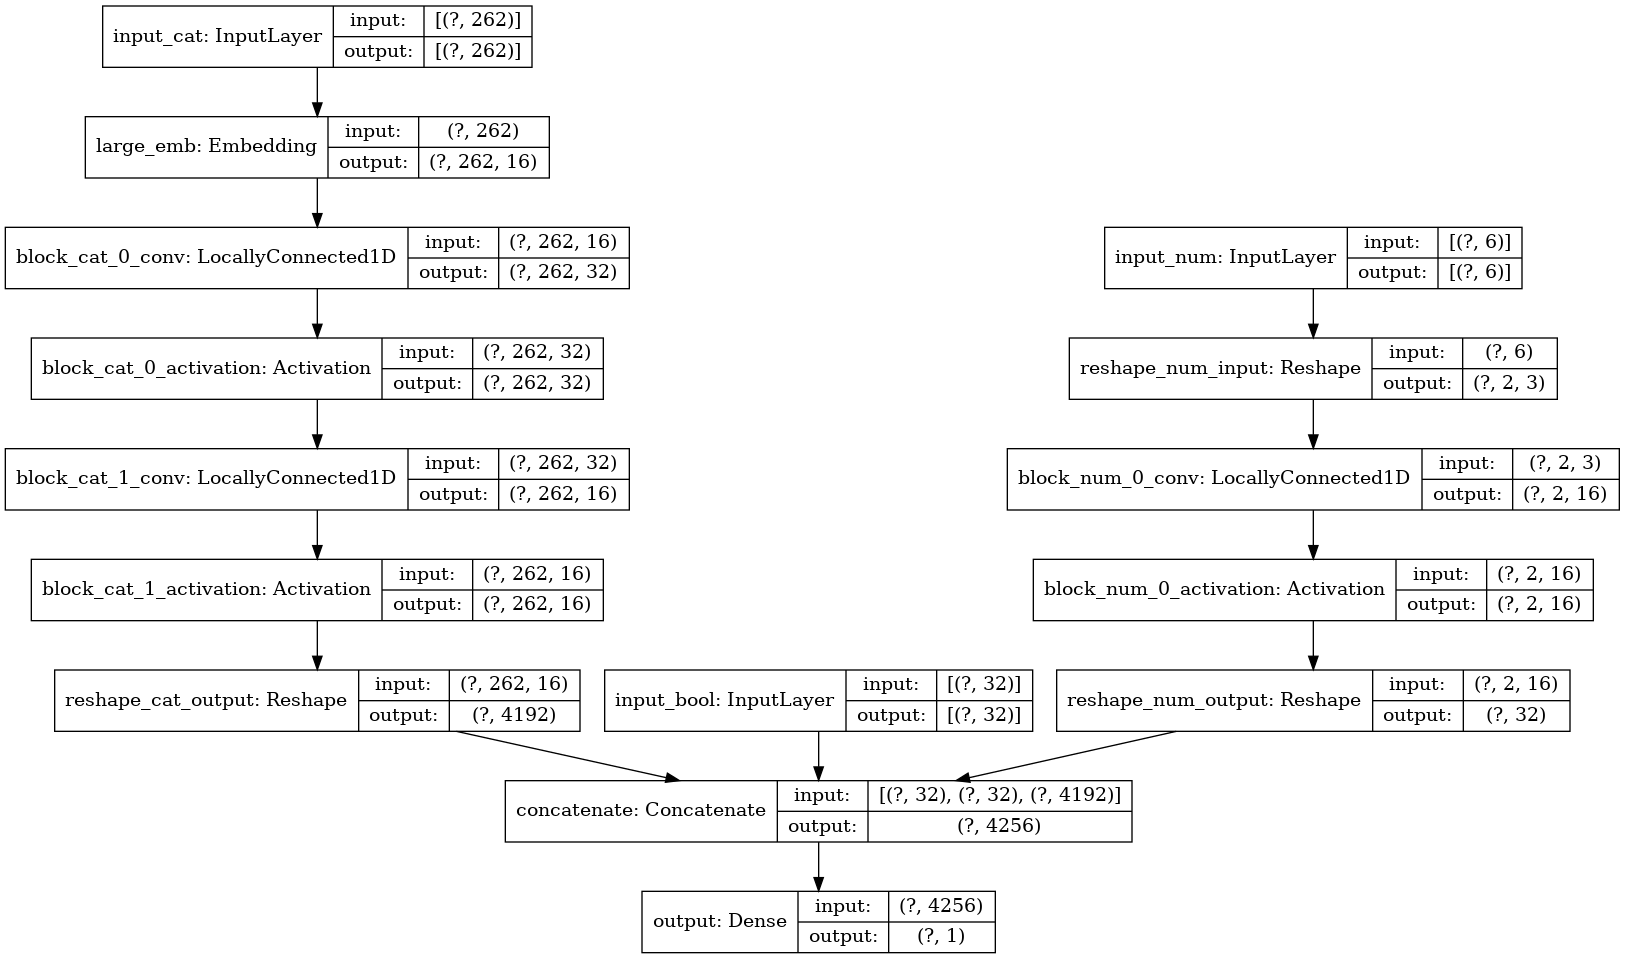

<IPython.core.display.Javascript object>

In [37]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [38]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

In [39]:
y_train.shape

(208603,)

<IPython.core.display.Javascript object>

In [40]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [41]:
class_weight = {
    0: counts[0],
    1: counts[1],
}
class_weight

{0: 1.2308196102263944, 1: 5.332387525562372}

<IPython.core.display.Javascript object>

In [ ]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)],
    class_weight=class_weight
)

Epoch 1/2000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
plot_history(history)

In [ ]:
model_auc = roc_auc_score(
    y_true=y_valid, y_score=model.predict(input_valid).reshape(-1),
)
model_auc

In [ ]:
# 0.945180869596132 => embeddign
# More cats 0.9499529383532423
# 0.9510084257679181 => 32 => 16

In [ ]:
# porto seguro 0.6232119567809998
# homesite-quote-conversion 0.9523864163447144
# cat in dat II 0.7664026194097782
# albert 0.7204053242303463
# census-income 0.937909089697099
# open payments 0.9259053788101843
# give-me-some-credit 0.8579704956990437
# bank-marketing 0.7783336895486428

In [ ]:
model_auc = roc_auc_score(y_true=y_test, y_score=model.predict(input_test).reshape(-1),)
model_auc

In [ ]:
# 0.9438800811761906 => embeddign
# More cats 0.9501807921285899
# 0.9500337101038149 => 32 => 16

In [ ]:
# porto seguro 0.6271530652897266
# homesite-quote-conversion 0.9551354942949817
# cat in dat II 0.759840080492485
# albert 0.7160934658045495
# census-income 0.9349738109864048
# open payments 0.9274364959503505
# give-me-some-credit 0.8559444719192335
# bank-marketing 0.804706871986707

In [ ]:
from thc_net.explainable_model.model import predict, encode

In [ ]:
probs, explanations = predict(model, input_test)

In [ ]:
probs, encoded_output = encode(model, input_test)

In [ ]:
y_test.shape

In [ ]:
encoded_output.shape

In [ ]:
probs[0], explanations[0].shape

In [ ]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

In [ ]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

In [ ]:
explain_plot(explanations[0], all_cols)
probs[0].item()

In [ ]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
np.unique(y_test, return_counts=True)

In [ ]:
y_test

In [ ]:
target_encoder.classes_

In [ ]:
confusion_matrix(
    y_true=y_test,
    y_pred=model.predict(input_test).reshape(-1) >= 0.5,
    # labels=target_encoder.classes_,
)